In [30]:
import gymnasium
import skyscraper
import numpy as np
from collections import defaultdict 

import random
import time

env = gymnasium.make('skyscraper/GridWorld-v0')

In [31]:
env.reset()

({'agent': {'pos': array([13,  5])}}, {'distance': 49, 'steps': 0})

In [32]:
env.step(1)

({'agent': {'pos': array([14.,  8.])}},
 0,
 False,
 False,
 {'distance': 46.0, 'steps': 1})

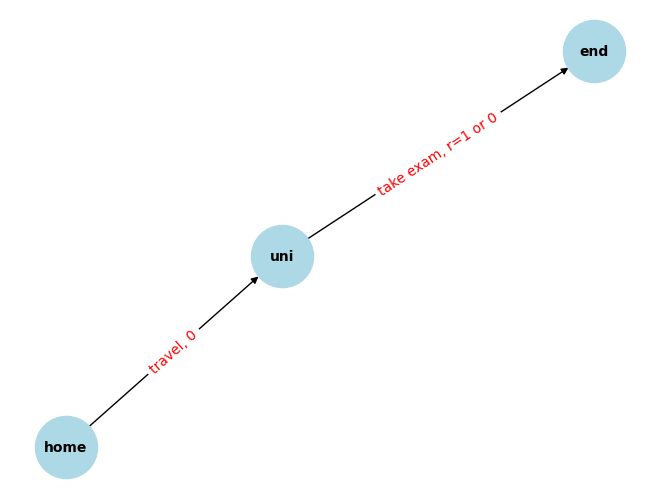

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Define the states and actions with rewards
states = ["home", "uni", "end"]
actions = {
    "home": [("uni", "travel", 0)],
    "uni": [("end", "take exam", "r=1 or 0")]
}

# Add nodes and edges with labels for each state and action
for state in states:
    G.add_node(state)

for source_state, action_list in actions.items():
    for target_state, action, reward in action_list:
        G.add_edge(source_state, target_state, label=f"{action}, {reward}")

# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()


## Env dynamics

In [34]:
# powered_flight_data = open('powered_flight.txt', 'r')
# powered_flight_data = powered_flight_data.read().split('\n')
# len(powered_flight_data)
# powered_flight_data


### First need to fix index problem, right know they are 1-indexed need to become 0-indexed bc env is 0-indexed.

In [35]:
# def fix_index(powered_flight_data):
#     fixed_data = []
#     for line in powered_flight_data:
#         data = line.strip().split('\t')
#         print(data)
#         if not data or len(data) != 6:
#              continue
        
#         try:
#             print("here")
#             adjusted_data = [int(value) - 1 if value else None for value in data]
#             # print("adjusted1: ",adjusted_data)
#             adjusted_data = [value for value in adjusted_data if value is not None]
#             # print("adjusted2: ",adjusted_data)
#             fixed_data.append(adjusted_data)
#         except ValueError as e:
#             print(f"Error processing line: {line} - {e}")
#     return fixed_data
# fixed_powered_flight_data = fix_index(powered_flight_data)
# fixed_powered_flight_data


In [36]:
# print(len(fixed_powered_flight_data))
# print(len(powered_flight_data))


In [37]:
a={1:1,2:3,4:5}

3 in a.values()

True

In [38]:
data = np.loadtxt('powered_flight.txt', dtype=int)
data[:,:3] -= 1
data[:,4:6] -= 1



### Transtition function, reward function and model M:

In [39]:
transition_function = {}  # Transition function: (state, action) -> next state

for i, j, a, r, i_prime, j_prime in data:
    
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    transition_function[(current_state, action)] = next_state
transition_function

{((17, 16), 0): (16, 12),
 ((3, 60), 0): (3, 56),
 ((11, 19), 1): (10, 22),
 ((16, 9), 1): (18, 11),
 ((7, 14), 0): (8, 11),
 ((2, 37), 0): (2, 34),
 ((17, 16), 1): (16, 20),
 ((4, 55), 0): (4, 51),
 ((3, 39), 1): (1, 42),
 ((2, 58), 1): (2, 63),
 ((2, 56), 1): (3, 60),
 ((1, 53), 0): (2, 51),
 ((9, 13), 1): (10, 16),
 ((18, 57), 1): (20, 60),
 ((1, 55), 0): (1, 52),
 ((7, 10), 1): (7, 14),
 ((3, 53), 1): (2, 56),
 ((10, 17), 0): (11, 14),
 ((5, 54), 0): (4, 51),
 ((5, 48), 0): (3, 44),
 ((3, 60), 1): (4, 63),
 ((2, 60), 0): (2, 57),
 ((6, 63), 1): (8, 55),
 ((9, 24), 0): (8, 21),
 ((0, 54), 1): (1, 58),
 ((3, 56), 1): (3, 60),
 ((1, 47), 1): (1, 52),
 ((6, 13), 1): (6, 17),
 ((3, 19), 1): (2, 22),
 ((11, 59), 1): (14, 62),
 ((8, 25), 0): (7, 22),
 ((13, 20), 1): (11, 22),
 ((21, 13), 0): (22, 11),
 ((3, 42), 1): (2, 45),
 ((4, 6), 1): (5, 9),
 ((1, 27), 1): (3, 31),
 ((1, 42), 0): (2, 40),
 ((1, 53), 1): (2, 57),
 ((7, 54), 1): (5, 58),
 ((10, 17), 1): (11, 20),
 ((15, 17), 1): (14, 2

In [40]:
reward_function = {}  # Reward function: (state, action, next state) -> reward

for i, j, a, r, i_prime, j_prime in data:
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    reward_function[(current_state, action)] = r
    
    
reward_function


{((17, 16), 0): 0,
 ((3, 60), 0): 0,
 ((11, 19), 1): 0,
 ((16, 9), 1): 0,
 ((7, 14), 0): 0,
 ((2, 37), 0): 0,
 ((17, 16), 1): 0,
 ((4, 55), 0): 0,
 ((3, 39), 1): 0,
 ((2, 58), 1): 0,
 ((2, 56), 1): 0,
 ((1, 53), 0): 0,
 ((9, 13), 1): 0,
 ((18, 57), 1): 0,
 ((1, 55), 0): 0,
 ((7, 10), 1): 0,
 ((3, 53), 1): 0,
 ((10, 17), 0): 0,
 ((5, 54), 0): 0,
 ((5, 48), 0): 0,
 ((3, 60), 1): 0,
 ((2, 60), 0): 0,
 ((6, 63), 1): 0,
 ((9, 24), 0): 0,
 ((0, 54), 1): 0,
 ((3, 56), 1): 0,
 ((1, 47), 1): 0,
 ((6, 13), 1): 0,
 ((3, 19), 1): 0,
 ((11, 59), 1): 0,
 ((8, 25), 0): 0,
 ((13, 20), 1): 0,
 ((21, 13), 0): 0,
 ((3, 42), 1): 0,
 ((4, 6), 1): 0,
 ((1, 27), 1): 0,
 ((1, 42), 0): 0,
 ((1, 53), 1): 0,
 ((7, 54), 1): 0,
 ((10, 17), 1): 0,
 ((15, 17), 1): 0,
 ((13, 58), 1): 0,
 ((12, 9), 1): 0,
 ((13, 5), 1): 0,
 ((5, 55), 1): 0,
 ((6, 57), 1): 0,
 ((16, 12), 1): 0,
 ((4, 25), 1): 0,
 ((1, 13), 1): 0,
 ((3, 22), 1): 0,
 ((5, 62), 0): 0,
 ((9, 18), 1): 0,
 ((11, 10), 0): 0,
 ((0, 61), 0): 0,
 ((24, 11), 0): 

In [41]:
def model_M(current_state, action, transition_function, reward_function):
   
    next_state = transition_function.get((current_state, action), None)  # Get the next state from T
    # print("next_state: ",next_state)
    reward = reward_function.get((current_state, action), 0)  # Get the reward from R
    # print("reward: ",reward)
    
    return next_state, reward
print(model_M((12, 17), 0, transition_function, reward_function))


((12, 13), 0)


## Dyna arcitecture:

In [42]:
action_space = [0, 1]  
alpha = 0.5
gamma = 0.99
epsilon = 0.3
n_planning_steps = 1000
# punishment=0.1
T = 1000  # Total number of real interactions
state = env.reset()[0]['agent']['pos']
state = tuple(state)


# Initialize Q-values
# Q = defaultdict(lambda: np.zeros(env.action_space.n))
Q=np.zeros((env.height,env.width,env.action_space.n))




In [43]:
# Choose action based on ε-greedy policy
def choose_action(state, Q, epsilon):
    if random.random() < epsilon:
        # print("random")
        return env.action_space.sample()  
    else:
        
        return np.argmax(Q[state])  

# Direct learning from real experience
# def q_learning_update(Q, state, action, reward, next_state, alpha, gamma):
    
#     best_next_action = np.argmax(Q[next_state])
    
#     td_target = reward + gamma * Q[next_state][best_next_action]
#     td_error = td_target - Q[state][action]
#     Q[state][action] += alpha * td_error
    
# def q_learning(Q, env, alpha, gamma, epsilon, num_episodes):
#     for episode in range(num_episodes):
#         state = env.reset()[0]['agent']['pos']
#         state = tuple(state)
#         done = False
        
#         while not done:
#             action = choose_action(state, Q, epsilon)
#             next_state, reward, done, _, _ = env.step(action)
#             next_state = tuple(map(int, next_state['agent']['pos']))
            
#             q_learning_update(Q, state, action, reward, next_state, alpha, gamma)
            
#             state = next_state
    
#     return Q

def q_learning(state, action, reward, next_state, value, discound,lr):

    # value of previous state-action pair
    i,j = state
    prev_value = value[i,j,action]

    # maximum Q-value at current state
    if next_state is None or np.isnan(next_state).any():
        max_value = 0
    else:
        n_i,n_j = next_state
        max_value = np.max(value[n_i,n_j, :])

    # reward prediction error
    delta = reward + discound * max_value - prev_value

    # update value of previous state-action pair
    value[i,j,action] = prev_value + lr * delta

    return value
    


In [44]:
def print_optimal_policy(Q):
   return np.argmax(Q,axis=2)
        # print(f"Optimal action for state {state} is {optimal_action}")

print_optimal_policy(Q)


# Main loop for Dyna-Q

for k in range(T):
    # epsilon = epsilon * 0.99
    # print(k)
    if k % 100 == 0:
        print(f"Real interaction {k}/{T}")
    
    state =env.reset()[0]['agent']['pos']
    state = tuple(state)
    start_state=state
    print("start state", start_state)
    # print("state: ",state)  
    done = False
    
    done = False
    while not done:
        
        
        action = choose_action(state, Q, epsilon)
        
        next_state, reward, done, err, info = env.step(action) 
        
        next_state = tuple(map(int,next_state['agent']['pos']))
        #print("next state", next_state)
        
        q_learning(state, action, reward, next_state, Q, gamma, alpha)
        transition_function[(state, action)] = next_state
        reward_function[(state, action)] = reward
        
        crashed  = (start_state==next_state and state != start_state)
        
        state = next_state
        #print("state", state)
        
        if done or crashed:
            done = True
        # print("state", state)
        
        
        
    # print('after')
    for m in range(n_planning_steps):
        # print("m: ",m)
        sampled_state, sampled_action = random.choice(list(transition_function.keys()))
        #sampled_action = random.choice(action_space)
        if (sampled_state, sampled_action) in transition_function:
            # simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action, transition_function, reward_function)
            simulated_next_state = transition_function[(sampled_state, sampled_action)]
            simulated_reward = reward_function[(sampled_state, sampled_action)]
            q_learning(sampled_state, sampled_action, simulated_reward, simulated_next_state,Q, gamma,alpha)
            # print('hi')

# env.close()
policy=print_optimal_policy(Q)
policy


Real interaction 0/1000
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
next state (15, 11)
state (15, 11)
next state (17, 7)
state (17, 7)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
next state (15, 11)
state (15, 11)
next state (17, 7)
state (17, 7)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
n

start state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
next state (15, 11)
state (15, 11)
next state (17, 13)
state (17, 13)
next state (18, 16)
state (18, 16)
next state (18, 19)
state (18, 19)
next state (16, 16)
state (16, 16)
next state (16, 12)
state (16, 12)
next state (18, 14)
state (18, 14)
next state (19, 17)
state (19, 17)
next state (19, 15)
state (19, 15)
next state (19, 19)
state (19, 19)
next state (17, 23)
state (17, 23)
next state (15, 20)
state (15, 20)
next state (13, 22)
state (13, 22)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (14, 8)
state (14, 8)
next state (13, 5)
state (13, 5)
start state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (13, 5)
state (13, 5)
next state (14, 8)
state (14, 8)
nex

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
# policy = np.argmax(Q,axis=2)
# policy

In [46]:
# Assuming other parts of your code remain unchanged
def run_with_policy(env, policy_matrix, num_steps=1000):
    observation, _ = env.reset()
    # Convert observation to initial position tuple
    current_pos = tuple(map(int, observation["agent"]["pos"]))

    for step in range(num_steps):
        if step % 10 == 0:
            print(f"Steps: {step} to {step + 99} of {num_steps}")

        # env.render()

        # Directly use current_pos to get the best action from the policy matrix
        action = policy_matrix[current_pos]
        print("action: ",action)
        #print(f"Action: {action}")

        # Take the action in the environment
        observation, reward, done, _, _ = env.step(action)

        # Update current position based on the observation
        current_pos = tuple(map(int, observation["agent"]["pos"]))
        
        print(f"Current Position: {current_pos}")

        if done:
            #print("Reached the goal or crashed, resetting.")
            observation, _ = env.reset()
            current_pos = tuple(map(int, observation["agent"]["pos"]))

    # env.close()

env = gymnasium.make('skyscraper/GridWorld-v0',render_mode="human")
print("Run with policy")
run_with_policy(env, policy)
# env.close()

Run with policy
Steps: 0 to 99 of 1000
action:  1
Current Position: (14, 8)
action:  1
Current Position: (15, 11)
action:  1
Current Position: (17, 13)
action:  1
Current Position: (18, 16)
action:  1
Current Position: (18, 19)
action:  0
Current Position: (16, 16)
action:  1
Current Position: (16, 18)
action:  1
Current Position: (16, 20)
action:  0
Current Position: (14, 16)
action:  1
Current Position: (14, 18)
Steps: 10 to 109 of 1000
action:  1
Current Position: (14, 20)
action:  1
Current Position: (12, 22)
action:  0
Current Position: (10, 19)
action:  1
Current Position: (9, 22)
action:  0
Current Position: (8, 19)
action:  1
Current Position: (7, 22)
action:  0
Current Position: (6, 19)
action:  1
Current Position: (5, 22)
action:  1
Current Position: (4, 25)
action:  1
Current Position: (3, 28)
Steps: 20 to 119 of 1000
action:  1
Current Position: (2, 31)
action:  1
Current Position: (3, 35)
action:  1
Current Position: (4, 37)
action:  1
Current Position: (5, 39)
action:  1


KeyboardInterrupt: 

In [ ]:
env.close()

In [ ]:
Q

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-5.85198506, -6.79346521],
        [ 0.        , -2.9701    ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-3.940399  , -6.79346521],
        [-3.940399  , -6.79346521],
        [-3.940399  , -6.79346521]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-4.90099501, -6.79346521],
        [-3.940399  , -6.79346521],
        [-3.940399  , -2.9701    ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.  

## Model development

<!-- power flight.txt in the format (i, j, a, r, i′.j′), where
(i, j) is the current state, a the action, r the reward, and (i′, j′) the next state. -->

In [ ]:
# def make_state_representations(fixed_powered_flight_data):
#     state_representation = {}
#     for data in fixed_powered_flight_data:
       
#         if not data or len(data) != 6:
#             continue
        
#         try:
#             i, j, a, r, i_prime, j_prime = map(int, data)  
            
#             a_new = -3 if a == 1 else 3
            
#             current_state = (i, j)
#             # print("current_state",current_state)
#             action = a_new
#             # print("action",action)
#             reward = r
#             # print("reward",reward)
#             next_state = (i_prime, j_prime)
#             # print("next_state",next_state)
            
#             if current_state not in state_representation:
#                 state_representation[current_state] = {
#                     'actions': {}, 
#                     'transitions': [],  
#                     'reward': 0  
#                 }
            
#             state_representation[current_state]['actions'][action] = next_state
            
#             if reward > state_representation[current_state]['reward']:
#                 state_representation[current_state]['reward'] = reward
                
#             state_representation[current_state]['transitions'].append((action, next_state, reward))
#             # print("state_representation",state_representation['transitions'])
            
#         except ValueError:
#             print(f"Error processing line: {data}")

#     return state_representation

# state_representation = make_state_representations(fixed_powered_flight_data)



In [ ]:
# state_representation[(6, 40)]

In [ ]:
        # def transtition_function